# Analisis Segmentasi Pelanggan dengan Dimensi FMD (KMeans VS DBSCAN)

## Dataset Online Retail 2010 (30.000 Baris)
Dataset mencakup beberapa kolom utama, yaitu Invoice, StockCode, Description, Quantity, InvoiceDate, Price, Customer ID, dan Country.

Dalam analisis ini, dilakukan perhitungan FMD (Frequency, Monetary, Diversity) per pelanggan dengan cara:

1. Frequency = jumlah invoice unik per pelanggan (berapa kali melakukan transaksi).

2. Monetary = total nilai belanja per pelanggan, dihitung dari penjumlahan (Quantity × Price).

3. Diversity = jumlah produk unik yang dibeli, berdasarkan StockCode unik.

Setelah transformasi fitur FMD, data dinormalisasi dan diuji dengan dua algoritma klasterisasi: KMeans dan DBSCAN. Eksperimen dilakukan untuk mencari jumlah klaster optimal, dengan mempertimbangkan minimal 3 klaster agar interpretasi dan rekomendasi bisnis tetap valid. Evaluasi model dilakukan menggunakan metrik Silhouette Score dan Davies-Bouldin Index (DBI) untuk mengukur kualitas pemisahan klaster.

Hasil akhir analisis menyajikan pembagian pelanggan ke dalam beberapa segmen berdasarkan pola belanja, tingkat keragaman produk yang dibeli, dan nilai transaksinya. Selanjutnya, dilakukan interpretasi mendalam terhadap tiap klaster, baik pada KMeans maupun DBSCAN, serta diberikan rekomendasi strategis yang dapat digunakan untuk mendukung pengambilan keputusan bisnis.

In [16]:
# 1. Import Library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors

In [17]:
# 2. Load & Preprocess Dataset

# 2.1 Load Dataset
df = pd.read_csv("/content/online retail 2010 30k.csv")

# 2.2 Preprocess Dataset
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)]
df = df[~df["StockCode"].str.contains("TEST", na=False)]

# 2.3 Perhitungan FMD (Frequency, Monetary, Diversity) per customer
fmd = df.groupby("Customer ID").agg({
    "Invoice": "nunique",
    "Quantity": lambda x: np.sum(x * df.loc[x.index, "Price"]),
    "StockCode": "nunique"
}).reset_index().rename(columns={
    "Invoice": "Frequency",
    "Quantity": "Monetary",
    "StockCode": "Diversity"
})

X_scaled = StandardScaler().fit_transform(fmd[["Frequency","Monetary","Diversity"]])
fmd[["PCA1","PCA2"]] = PCA(n_components=2).fit_transform(X_scaled)

k=2 → Silhouette=0.8939, DBI=0.7429
k=3 → Silhouette=0.5781, DBI=0.8797
k=4 → Silhouette=0.5783, DBI=0.8250
k=5 → Silhouette=0.5773, DBI=0.9095
k=6 → Silhouette=0.5294, DBI=0.7841
k=7 → Silhouette=0.5350, DBI=0.9026
k=8 → Silhouette=0.5351, DBI=0.7798
k=9 → Silhouette=0.5361, DBI=0.7312
k=10 → Silhouette=0.4031, DBI=0.7700


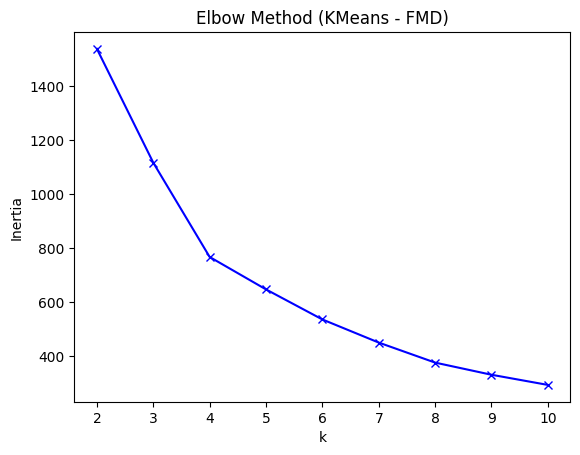


Evaluasi KMeans: 0.5781203987261296 0.8797320976784192


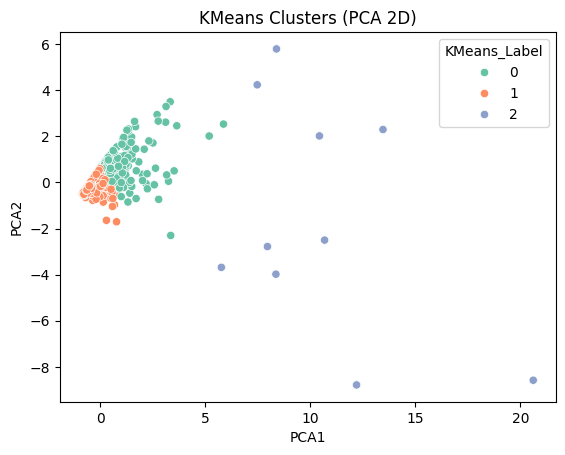


Ringkasan KMeans:
              Frequency      Monetary   Diversity  Customer ID
KMeans_Label                                                  
0              2.303191   1172.305644   64.861702          188
1              1.143875    392.682070   17.582621          702
2             12.200000  20031.119000  166.100000           10


In [18]:
# 3. Fit KMeans dan Hasil akhir

# 3.1 Visualisasi Elbow Plot dan Eksperimen K
inertia, sil_scores, dbi_scores = [], [], []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
    labels = km.labels_
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))
    dbi_scores.append(davies_bouldin_score(X_scaled, labels))
    print(f"k={k} → Silhouette={sil_scores[-1]:.4f}, DBI={dbi_scores[-1]:.4f}")

plt.plot(range(2,11), inertia, 'bx-')
plt.title("Elbow Method (KMeans - FMD)"); plt.xlabel("k"); plt.ylabel("Inertia"); plt.show()

# 3.2 Fit KMeans berdasarkan hasil eksperimen
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_scaled)
fmd["KMeans_Label"] = kmeans.labels_
print("\nEvaluasi KMeans:",
      silhouette_score(X_scaled, fmd["KMeans_Label"]),
      davies_bouldin_score(X_scaled, fmd["KMeans_Label"]))

# 3.3 Visualisasi Scatterplot PCA 1 dan PCA 2
sns.scatterplot(data=fmd, x="PCA1", y="PCA2", hue="KMeans_Label", palette="Set2")
plt.title("KMeans Clusters (PCA 2D)"); plt.show()

# 3.4 Ringkasan output kluster KMeans
print("\nRingkasan KMeans:")
print(fmd.groupby("KMeans_Label").agg({"Frequency":"mean","Monetary":"mean",
                                       "Diversity":"mean","Customer ID":"count"}))

# Interpretasi KMeans (k=3)

### Cluster 0 (188 pelanggan)

1. Frequency: rendah (±2 kali transaksi)

2. Monetary: sedang (±1172)

3. Diversity: sedang (±65 produk)

### Interpretasi:

Kelompok pelanggan bernilai menengah dengan jumlah transaksi jarang, namun sekali belanja bernilai cukup besar dan pembelian produk yang cukup beragan. Pola belanja cenderung bulk sekaligus, memberi kontribusi signifikan meski bukan terbesar.
Kemungkinan korporat kecil atau komunitas yang cukup loyal.

---

### Cluster 1 (702 pelanggan)

1. Frequency: sangat rendah (±1 kali transaksi)

2. Monetary: rendah (±393)

3. Diversity: rendah (±18 produk)

### Interpretasi:

Kelompok pelanggan umum dan terbesar, dengan frekuensi traksasi sangat rendah, nilai belanja yang kecil, dan produk yang kurang beragam. Kontribusi revenue minim, mayoritas hanya beli sekali untuk kebutuhan spesifik.
Kemungkinan pembeli individu yang sesekali berbelanja.

---

### Cluster 2 (10 pelanggan)

1. Frequency: tinggi (±12 kali transaksi)

2. Monetary: sangat tinggi (±20.031)

3. Diversity: sangat tinggi (±166 produk)

### Interpretasi:

Kelompok pelanggan kecil dan eksklusif, dengan frekuensi transaksi tinggi, nilai belanja yang sangat besar, dan produk yang sangat beragam. ini adalah Pelanggan premium (VIP) dengan kontribusi tinggi dan loyalitas kuat. Kemungkinan grosir atau reseller.

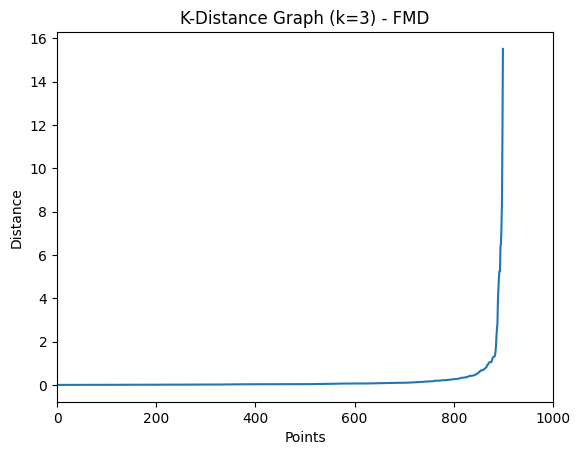


Hasil Eksperimen DBSCAN:
    eps  min_samples  clusters  noise_points  silhouette       DBI
0   0.3            3         6            59    0.339065  1.428896
1   0.3            5         5            65    0.335962  1.525738
2   0.3           10         3            96    0.325391  1.552727
3   0.5            3         5            40    0.323833  1.507849
4   0.5            5         4            44    0.326192  1.539860
5   0.5           10         3            62    0.324406  1.551480
6   0.7            3         3            26    0.653062  1.363855
7   0.7            5         2            29    0.729673  1.241915
8   0.7           10         1            38         NaN       NaN
9   1.0            3         1            15         NaN       NaN
10  1.0            5         2            16    0.718825  1.090202
11  1.0           10         1            26         NaN       NaN
12  1.5            3         1            14         NaN       NaN
13  1.5            5         1      

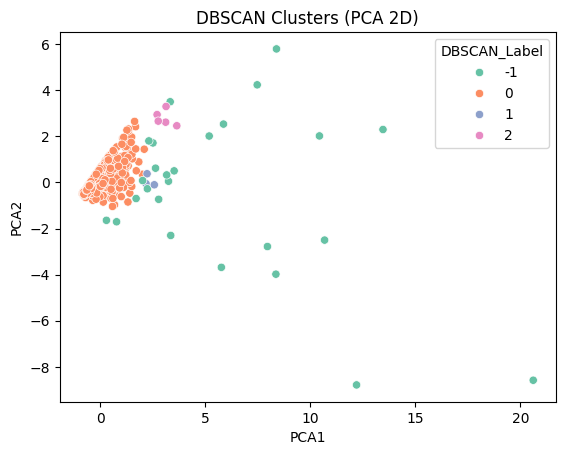


Ringkasan DBSCAN:
              Frequency      Monetary   Diversity  Customer ID
DBSCAN_Label                                                  
-1             7.615385  10082.894231  113.115385           26
 0             1.300231    486.490490   25.781755          866
 1             6.000000   1553.416667   49.666667            3
 2             3.200000   1650.240000  156.200000            5


In [21]:
# 4. Fit DBSCAN dan Hasil akhir

# 4.1 Visualisasi K-Distance Graph dan Eksperimen Eps - Min Sample
distances, _ = NearestNeighbors(n_neighbors=5).fit(X_scaled).kneighbors(X_scaled)
plt.plot(np.sort(distances[:,-1]))
plt.title("K-Distance Graph (k=3) - FMD")
plt.xlabel("Points"); plt.ylabel("Distance")
plt.xlim(0,1000); plt.show()

results = []
for eps in [0.3,0.5,0.7,1.0,1.5]:
    for ms in [3,5,10]:
        db = DBSCAN(eps=eps, min_samples=ms).fit(X_scaled)
        lbl = db.labels_; n_clusters = len(set(lbl)) - (1 if -1 in lbl else 0)
        n_noise = list(lbl).count(-1)
        sil, dbi = (None, None)
        if n_clusters > 1:
            sil, dbi = silhouette_score(X_scaled, lbl), davies_bouldin_score(X_scaled, lbl)
        results.append({"eps":eps,"min_samples":ms,"clusters":n_clusters,
                        "noise_points":n_noise,"silhouette":sil,"DBI":dbi})
print("\nHasil Eksperimen DBSCAN:")
print(pd.DataFrame(results))

# 4.2 Fit DBSCAN berdasarkan hasil eksperimen
dbscan = DBSCAN(eps=0.7, min_samples=3).fit(X_scaled)
fmd["DBSCAN_Label"] = dbscan.labels_

# 4.3 Visualisasi Scatterplot PCA 1 dan PCA 2
sns.scatterplot(data=fmd, x="PCA1", y="PCA2", hue="DBSCAN_Label", palette="Set2")
plt.title("DBSCAN Clusters (PCA 2D)"); plt.show()

# 4.4 Ringkasan output kluster DBSCAN
print("\nRingkasan DBSCAN:")
print(fmd.groupby("DBSCAN_Label").agg({"Frequency":"mean","Monetary":"mean",
                                       "Diversity":"mean","Customer ID":"count"}))

# Interpretasi DBSCAN (eps=0.7, min_samples=3)

### Cluster 0 (866 pelanggan)

1. Frequency: sangat rendah (±1 kali transaksi)

2. Monetary: rendah (±486)

3. Diversity: rendah (±26 produk)

### Interpretasi:

Kelompok pelanggan terbesar dan umum dengan kontribusi revenue kecil. Mereka hanya melakukan pembelian sekali atau sangat jarang dengan nilai dan variasi produk rendah.
Kemungkinan pembeli individu sekali waktu yang loyalitasnya minim.

---

### Cluster 1 (3 pelanggan)

1. Frequency: menengah (±6 kali transaksi)

2. Monetary: sedang (±1.553)

3. Diversity: sedang (±50 produk)

### Interpretasi:

Kelompok sangat kecil dengan transaksi rutin, nilai belanja menengah, dan variasi produk cukup banyak.
Kemungkinan pelanggan setia skala kecil, seperti bisnis kecil atau pelanggan individu yang cukup loyal.

---

### Cluster 2 (5 pelanggan)

1. Frequency: rendah (±3 kali transaksi)

2. Monetary: sedang (±1.650)

3. Diversity: sangat tinggi (±156 produk)

### Interpretasi:

Kelompok kecil dengan belanja tidak sering, tetapi sekali belanja nilainya besar dan produknya sangat beragam.
Pola belanja bulk, kemungkinan korporat kecil atau komunitas yang membeli untuk kebutuhan banyak orang sekaligus.

---

### Noise -1 (26 pelanggan)

1. Frequency: tinggi (±8 kali transaksi)

2. Monetary: sangat tinggi (±10.083)

3. Diversity: tinggi (±113 produk)

### Interpretasi:

Kelompok pelanggan yang ditandai sebagai **noise** (bukan cluster inti), namun justru menunjukkan perilaku pembelian besar, sering, dan beragam.
Mereka kemungkinan outlier premium seperti grosir atau reseller dengan pola belanja tidak umum dibanding mayoritas pelanggan.
Tetap penting untuk diperhatikan meskipun tidak terklasifikasi dalam cluster inti.

# Kesimpulan

1. Total pelanggan unik = 900, terbagi dalam beberapa segmen dengan karakteristik berbeda.

2. Mayoritas pelanggan termasuk segmen bernilai rendah dengan frekuensi belanja sekali, nilai kecil, dan variasi produk sedikit. Kontribusi revenue sangat minim.

3. Pelanggan bernilai menengah membeli dalam jumlah sedang, kadang bulk, dengan variasi produk cukup tinggi. Kontribusi revenue lumayan.

4. Pelanggan premium (10 orang di KMeans, 26 noise di DBSCAN) punya pola pembelian besar, sering, dan variasi sangat beragam. Segmen kecil dan eksklusif namun menyumbang revenue terbesar.

5. KMeans lebih stabil, menghasilkan 3 segmen yang jelas (low, medium, premium), sedangkan DBSCAN lebih detail.

# Rekomendasi

### Segmen Low Value (mayoritas pelanggan):

1. Edukasi & promosi ringan (diskon, email marketing) untuk meningkatkan frekuensi belanja.

2. Fokus pada upselling/cross-selling agar nilai belanja naik.

3. Jangan terlalu banyak alokasi biaya akuisisi, karena potensi revenue relatif rendah.

### Segmen Medium Value (pembeli borongan):

1. Dorong pembelian rutin dengan program loyalty sederhana (poin belanja, voucher belanja berikutnya).

2. Bisa diarahkan ke produk bundling atau paket hemat untuk memperkuat pola bulk purchase.

### Segmen Premium / VIP (grosir, reseller):

1. Jumlah pelanggan kecil (sekitar 3% dari keseluruhan), tapi kontribusi revenue sangat besar.

2. Harus diprioritaskan dalam retensi melalui layanan khusus, dedicated account manager, diskon eksklusif, atau program VIP membership.

3. Membutuhkan pendekatan personalisasi agar loyalitas terjaga dan tidak berpindah ke kompetitor.

4. Termasuk pelanggan “tidak biasa” (noise di DBSCAN) yang tetap penting, sehingga perlu identifikasi manual untuk strategi khusus